In [1]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys

sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [5]:
#lt = gpd.read_file("/projects/2023_lightning_data/englnrt_20230530_daily_v1_lit.raw")
# lt = pd.read_csv("/projects/2023_lightning_data/englnrt_20230530_daily_v1_lit.raw", names =["InterCloud",
#                                                                                              "t", 
#                                                                                              "lat", 
#                                                                                              "lon",
#                                                                                              "current_mag", 
#                                                                                              "multiplicity_0", 
#                                                                                              "accr", 
#                                                                                              "error_elps", 
#                                                                                              "num_station"])

#lt = pd.read_parquet(path = "/projects/2023_lightning_data/englnrt_20230530_daily_v1_lit.raw")
#?pd.read_parquet

In [7]:
#?pd.read_csv

In [2]:
#?gpd.read_file
#?pd.read_csv

In [3]:
#lt =  gpd.GeoDataFrame(lt, geometry=gpd.points_from_xy(lt['lon'], lt['lat']))

In [4]:
#lt.t = lt.t.astype("datetime64[ns]")

In [5]:
#lt = lt[lt.InterCloud == 0]

In [6]:
### Too many points to plot. Cheat by chopping up the lat and lon readings? 

# lt.lat_r = lt.lat.round(2)
# lt.lon_r = lt.lon.round(2)

In [7]:
# sm = lt[["InterCloud", "lat_r", "lon_r"]]
# sm = sm.drop_duplicates()
# sm = gpd.GeoDataFrame(sm, 
#                       geometry=gpd.points_from_xy(sm['lon_r'], sm['lat_r']))

In [8]:
# print(len(lt))
# len(sm)

# sm.set_crs("4326")

In [9]:
# smol = sm.geometry.sample(100)
# smol = smol.set_crs("epsg:4326")

In [10]:

# plt.figure()
# ax = plt.subplot()
# plot = smol.plot(ax = ax)
# cx.add_basemap(plot, crs=smol.crs.to_string(), attribution = False) 

In [11]:
# ### Subset to canada, using our boreal bbox
# from shapely.geometry import box

    
    
    

# CA_bbox = box(-169, 44, -48, 75)
# lt = lt.set_crs("epsg:4326")

# smol = lt.clip(CA_bbox)

In [12]:
# smol = smol.set_crs("epsg:4326")

# plt.figure()
# ax = plt.subplot()
# plot = smol.plot(ax = ax, alpha=0.2)
# cx.add_basemap(plot, crs=smol.crs.to_string(), attribution = False) ## Projection issues??

In [13]:
# smol.t = smol.t.astype("str")
# #smol.explore()

In [2]:
#df = pd.read_csv('example.csv')
#df.to_parquet('output.parquet')
#?pd.read_parquet

# import sys
# import pandas as pd
# import geopandas as gpd
# import dask.dataframe as dd
# import dask_geopandas

In [2]:
### Try to make a low-memory conversion



import pyarrow as pa
import pyarrow.parquet as pq

new_schema = pa.schema([
    ('InterCloud', pa.int64()),
    ('t', pa.string()),
    ('lat', pa.float64()),
    ('lon', pa.float64()),
    ("current_mag", pa.float64()),
    ("multiplicity_0", pa.int64()),
    ("accr", pa.float64()),
    ("error_elps", pa.float64()),
    ("num_station", pa.float64())
    
])

csv_column_list = ["InterCloud", "t", "lat", "lon", "current_mag", "multiplicity_0", "accr", 
                   "error_elps", 
                   "num_station"]

csvs_regex = '/projects/2023_lightning_data/e*.raw'

In [3]:
import re

#files2 = glob.glob("/projects/2023_lightning_data/e*")

dates = ['20230406', '20230430', '20231018', '20231025']

fls = []
for d in dates:
    fl = "/projects/2023_lightning_data/englnrt_"+d+"_daily_v1_lit.raw"
    fls.append(fl)
fls

['/projects/2023_lightning_data/englnrt_20230406_daily_v1_lit.raw',
 '/projects/2023_lightning_data/englnrt_20230430_daily_v1_lit.raw',
 '/projects/2023_lightning_data/englnrt_20231018_daily_v1_lit.raw',
 '/projects/2023_lightning_data/englnrt_20231025_daily_v1_lit.raw']

In [4]:
files2 = fls
#files2 = glob.glob("/projects/2023_lightning_data/englnrt_20230727_daily_v1_lit.raw")
files  = pd.DataFrame(files2)
#names = replace("/projects/2023_lightning_data/", "")  
names = files[0].str.replace("/projects/2023_lightning_data/", "") 
names = names.str.replace(".raw", "")
#re.split(by = "/", files)
#?re.split

#names

/tmp/ipykernel_4389/3720831474.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  names = names.str.replace(".raw", "")


In [21]:
for f,n in zip(files2, names):
    print(f)
    with pq.ParquetWriter('/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/parrow_parquet/' + n + '.parquet', schema=new_schema) as writer:
        with pd.read_csv(f, header=None, names=csv_column_list, chunksize=100000) as reader:
    #with dd.read_csv(csvs_regex, header=None, names=csv_column_list) as reader:
            for df in reader:
                # transformation: transform df by adding a new static column with column name 'newcol' and value 9999999
                # convert pandas df to record batch
                transformed_batch = pa.RecordBatch.from_pandas(df, schema=new_schema)
                writer.write_batch(transformed_batch) 

 

/projects/2023_lightning_data/englnrt_20230406_daily_v1_lit.raw
/projects/2023_lightning_data/englnrt_20230430_daily_v1_lit.raw
/projects/2023_lightning_data/englnrt_20231018_daily_v1_lit.raw
/projects/2023_lightning_data/englnrt_20231025_daily_v1_lit.raw


ArrowInvalid: ('Could not convert \'<!DOCTYPE html PUBLIC "-//W3C//DTD XHTML 1.0 Transitional//EN" "http://www.w3.org/TR/xhtml1/DTD/xhtml1-transitional.dtd">\' with type str: tried to convert to int64', 'Conversion failed for column InterCloud with type object')

In [5]:
def get_ca_lt(date, chunk_size, bbox = [-169, 44, -48, 75]): #[-169, 44, -48, 75] [-83.69877641421793, 44.25483911637959, -55, 62.94135765648493]
    CA_bbox = box(bbox[0], bbox[1], bbox[2], bbox[3])
    print(date)
    
    #lt = pd.read_csv("/projects/my-public-bucket/Lighting_data/2023/englnrt_"+ date+"_daily_v1_lit.raw", names =["InterCloud",
    lt = pd.read_csv("/projects/2023_lightning_data/englnrt_"+ date+"_daily_v1_lit.raw", names =["InterCloud",
                                                                                             "t", 
                                                                                             "lat", 
                                                                                             "lon",
                                                                                             "current_mag", 
                                                                                             "multiplicity_0", 
                                                                                             "accr", 
                                                                                             "error_elps", 
                                                                                             "num_station"], chunksize = chunk_size)
    
    lt = list(lt) #pd.concat(tp, ignore_index=True)
    lt =  gpd.GeoDataFrame(lt, geometry=gpd.points_from_xy(lt['lon'], lt['lat']))
    lt.t = lt.t.astype("datetime64[ns]")
    lt = lt[lt.InterCloud == 0]
    lt = lt.set_crs("epsg:4326")
    smol = lt.clip(CA_bbox)
    return(smol)

def get_ca_lt_parquet(date, bbox = [-169, 44, -48, 75]): #[-169, 44, -48, 75] [-83.69877641421793, 44.25483911637959, -55, 62.94135765648493]
    CA_bbox = box(bbox[0], bbox[1], bbox[2], bbox[3])
    print(date)
    
    #lt = pd.read_csv("/projects/my-public-bucket/Lighting_data/2023/englnrt_"+ date+"_daily_v1_lit.raw", names =["InterCloud",
    lt = pd.read_parquet("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/parrow_parquet/englnrt_"+ date+"_daily_v1_lit.parquet", columns =["InterCloud",
                                                                                             "t", 
                                                                                             "lat", 
                                                                                             "lon",
                                                                                             "current_mag", 
                                                                                             "multiplicity_0", 
                                                                                             "accr", 
                                                                                             "error_elps", 
                                                                                             "num_station"])
    lt =  gpd.GeoDataFrame(lt, geometry=gpd.points_from_xy(lt['lon'], lt['lat']))
    lt.t = lt.t.astype("datetime64[ns]")
    lt = lt[lt.InterCloud == 0]
    lt = lt.set_crs("epsg:4326")
    smol = lt.clip(CA_bbox)
    return(smol)

def plot_ca(smol, title = " ", bbox = [-169, 44, -48, 75] ):
    plt.figure()
    ax = plt.subplot()
    plot = smol.plot(ax = ax, alpha=0.2)
    plot.set_xlim(bbox[0], bbox[2])
    plot.set_ylim(bbox[1], bbox[3])
    cx.add_basemap(plot, crs=smol.crs.to_string(), attribution = False)
    ax.set_title(title)
    plt.show()

In [7]:
smol = get_ca_lt("20230530")
plot_ca(smol)

TypeError: get_ca_lt() missing 1 required positional argument: 'chunk_size'

In [2]:
date_range = pd.date_range(start = "2023-04-01 12:00:00", end = "2023-10-25 00:00:00", freq="24H")

date_snap = date_range.strftime("%Y%m%d")
date_snap
nice_dates = date_range.strftime("%Y-%m-%d")

20230525


/projects/myenvs/fireatlas_oct4/lib/python3.8/site-packages/geopandas/plotting.py:693: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  warnings.warn(


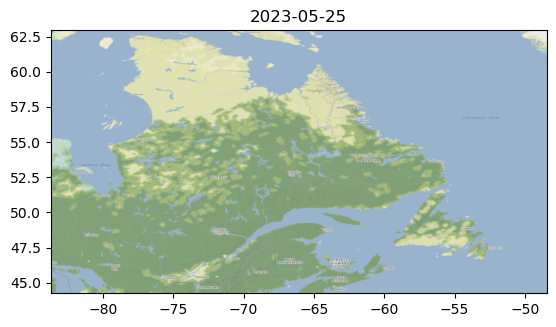

20230526


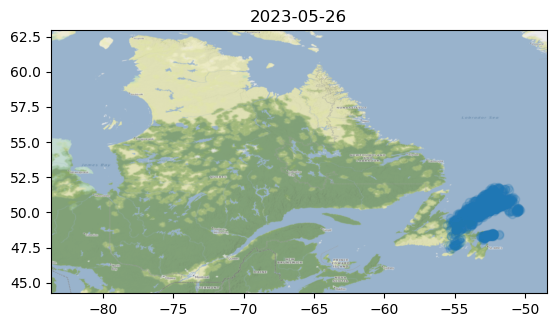

20230527


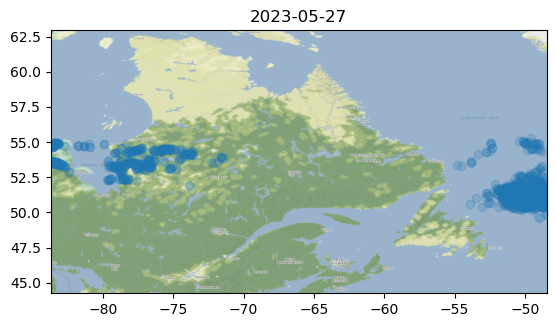

20230528


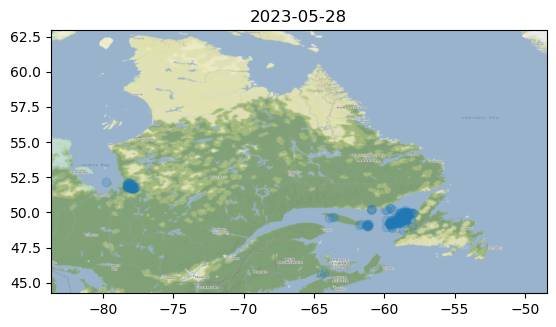

20230529


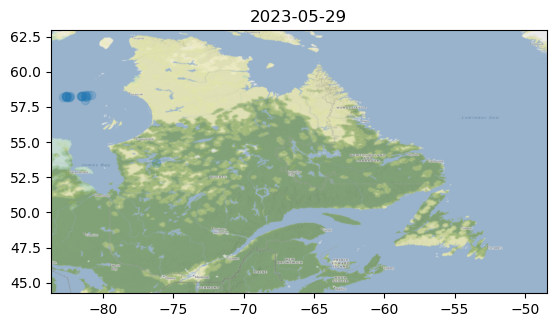

20230530


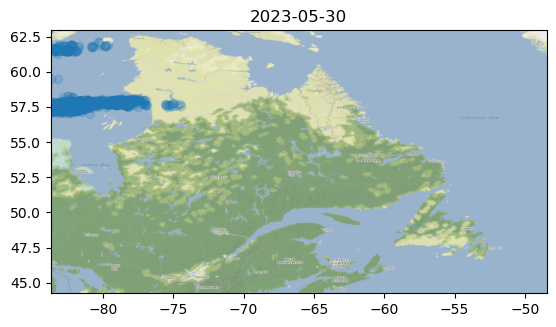

20230531


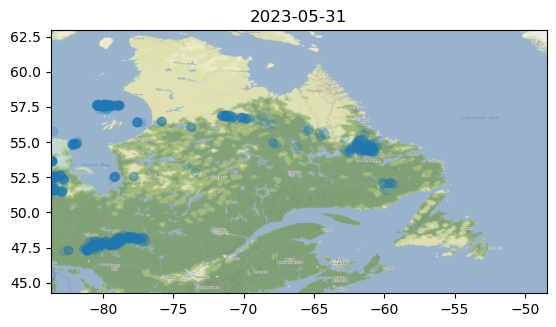

In [26]:
# for d,n in zip(date_snap,nice_dates) :
#     print(d)
#     bbox = [-83.69877641421793, 44.25483911637959, -55, 62.94135765648493]
#     smol = get_ca_lt(str(d), bbox  = bbox)
#     plot_ca(smol, title = n, bbox = bbox)
    

In [3]:
## Make an overall lightning timing
import time
from datetime import date
import traceback



def lt_timeseries_extract(date_snap, region, sub_region, run_name): ## putting into function because might help memory???
    
    run_name = str(date.today()) + run_name_st
    lt = [] # full info per day
    bad_ids = [] # list of IDs that failed due to error
    bbox = [-83.69877641421793, 44.25483911637959, -55, 62.94135765648493]
    for n,i in enumerate(date_snap, start = 0):

        try:
            smol = get_ca_lt(str(i), bbox = bbox )

        except Exception as e:
            print("Error at date: ",n,)
            bad_log = traceback.format_exc(limit = 40) # Get log of error
            print(bad_log)
            bad_ids.append(
            {
                "date": n, 
                "log": bad_log
            }
            )
        lt.append(smol)
        if((n%1 == 0) | (n == (len(date_range) -1))):
            print("")
            manyfr = gpd.GeoDataFrame(pd.concat(lt, ignore_index=True), crs= smol.crs)
            manyfr.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_" + region + "_" + sub_region +  "_" + run_name +".csv")
            debug = pd.DataFrame(bad_ids)
            debug.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/DEBUG_" + region + "_" + sub_region + "_" + run_name + ".csv")
        
    return(manyfr)

def lt_timeseries_extract_pq(date_snap, region, sub_region, run_name): ## putting into function because might help memory???
    
    run_name = str(date.today()) + run_name_st
    #lt = [] # full info per day
    bad_ids = [] # list of IDs that failed due to error
    bbox = [-169, 44, -48, 75]#[-83.69877641421793, 44.25483911637959, -55, 62.94135765648493] #[-169, 44, -48, 75] #[-83.69877641421793, 44.25483911637959, -55, 62.94135765648493]
    for n,i in enumerate(date_snap, start = 0):

        try:
            smol = get_ca_lt_parquet(str(i), bbox = bbox )

        except Exception as e:
            print("Error at date: ",n,)
            bad_log = traceback.format_exc(limit = 40) # Get log of error
            print(bad_log)
            bad_ids.append(
            {
                "date": n, 
                "log": bad_log
            }
            )
        #lt.append(smol)
        if((n%1 == 0) | (n == (len(date_range) -1))):
            print("")
            manyfr = gpd.GeoDataFrame(smol, crs= smol.crs)
            manyfr.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_" + region + "_" + sub_region +  "_" + run_name +i+".csv")
            debug = pd.DataFrame(bad_ids)
            debug.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/DEBUG_" + region + "_" + sub_region + "_" + run_name + i+".csv")
        
    return(manyfr)

In [4]:
import time
from datetime import date
import traceback



def lt_timeseries_extract_low_mem(date_snap, region, sub_region, run_name): ## putting into function because might help memory???
    
    run_name = str(date.today()) + run_name_st
    #lt = [] # full info per day
    bad_ids = [] # list of IDs that failed due to error
    bbox = [-83.69877641421793, 44.25483911637959, -55, 62.94135765648493]
    for n,i in enumerate(date_snap, start = 0):

        try:
            smol = get_ca_lt(str(i), chunk_size = 1000, bbox = bbox )

        except Exception as e:
            print("Error at date: ",i,)
            bad_log = traceback.format_exc(limit = 40) # Get log of error
            print(bad_log)
            bad_ids.append(
            {
                "date": n, 
                "log": bad_log
            }
            )
        #lt.append(smol)
        if((n%1 == 0) | (n == (len(date_range) -1))):
            print("")
            manyfr = gpd.GeoDataFrame(smol, crs= smol.crs)
            manyfr.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_" + region + "_" + sub_region +  "_" + run_name +i+".csv")
            debug = pd.DataFrame(bad_ids)
            debug.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/DEBUG_" + region + "_" + sub_region + "_" + run_name + i+".csv")
            del manyfr
        


In [4]:
# 20230727
date_range = pd.date_range(start = "2023-10-17 00:00:00", end = "2023-10-19 00:00:00", freq="24H")

date_snap = date_range.strftime("%Y%m%d")
date_snap
nice_dates = date_range.strftime("%Y-%m-%d")

In [5]:
# ##Grab Currrent Time Before Running the Code
# start = time.time()

# ################# Horrible for loop ##################
# sub_region = "Boreal"
# region =  "CA"
# #year = "2023"
# run_name_st = "All_canada_oct25_0401_0407"
# manyfr = lt_timeseries_extract_pq(date_snap = date_snap, region = region,  sub_region = sub_region, run_name = run_name_st) ## putting into function because might help memory???

# # Grab Currrent Time After Running the Code
# end = time.time()

# #Subtract Start Time from The End Time
# total_time = end - start
# print("\n"+ str(total_time))

In [31]:
#client.cancel()
#client.restart()
#client.close()
#client

In [4]:
# from dask.distributed import Client

# client = Client("tcp://127.0.0.1:40099")
# client

In [4]:
### Try to dask-parallelize this.

## Get dask client

In [ ]:
# from dask.distributed import Client

# client = Client("tcp://127.0.0.1:36779")
# client

In [5]:
# from dask.distributed import Client

# client = Client("tcp://127.0.0.1:38291")
# client


# from dask.distributed import Client, progress
# client = Client(threads_per_worker=2, n_workers=3)
# client

In [32]:
# import dask

# lazy_results = []

# for d in date_snap:
#     tmp = dask.delayed(get_ca_lt)(str(d))
#     lazy_results.append(tmp)

# futes = dask.persist(*lazy_results)  # trigger computation in the background

In [27]:
#client.cancel(futes)


In [6]:

# results = dask.compute(*futes)
# #results = dask.compute(*lazy_results)

In [30]:
#results
#date_snap

NameError: name 'results' is not defined

In [8]:
files = glob.glob("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_CA_Boreal_*.csv")
#files

In [9]:
def concat_subsets(files):
    df = []
    for f in files:
        manyfr = pd.read_csv(f)

        manyfr = gpd.GeoDataFrame(manyfr)

        manyfr.t = manyfr.t.astype("datetime64[ns]")
        df.append(manyfr)
    df = pd.concat(df)
    return(df)

#manyfr = pd.concat([manyfr, manyfr2])

manyfr= concat_subsets(files)
#manyfr = manyfr.drop_duplicates()

#manyfr2 = pd.read_csv('/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/Lt_CA_Quebec_2023-10-05base_stats_20230616.csv')

# manyfr = gpd.GeoDataFrame(manyfr)

# manyfr.t = manyfr.t.astype("datetime64[ns]")

In [10]:
prov = fv.ca_prov()
manyfr = gpd.GeoDataFrame(manyfr, geometry=gpd.points_from_xy(manyfr.lon, manyfr.lat), crs=4326) #4674
manyfr= manyfr.sjoin(prov)
manyfr = manyfr.to_crs("3571")
## SUBSET lt to quebec
manyfr = manyfr[manyfr.prov_name_en == 'Quebec']

In [20]:
#n_strike = manyfr.groupby("t").count()

In [55]:
#manyfr = manyfr.sort_values( by = "t")

In [56]:
#print(manyfr.t.max())
#print(manyfr2.t.max())

2023-06-23 23:59:43.962000
2023-06-21 23:59:59.109


In [11]:
import time
from datetime import date

am = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
pm = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]



manyfr["day"] = manyfr.t.dt.day
manyfr["hour"] = manyfr.t.dt.hour
manyfr["is_am"] = manyfr.hour.isin(am)
manyfr["t_agg"] = manyfr.t.dt.strftime("%Y-%m-%d %H:00:00")
manyfr.t = manyfr.t.dt.tz_localize("UTC")


In [11]:
#manyfr.t.dt.tz_localize("UTC")

In [24]:
#n_strike.hour.unique()

In [12]:
day_strike = manyfr.groupby('t_agg').count()
#day_strike["t"] = day_strike.index
day_strike.index

Index(['2023-04-05 10:00:00', '2023-04-05 11:00:00', '2023-04-05 13:00:00',
       '2023-04-05 14:00:00', '2023-04-05 15:00:00', '2023-04-05 16:00:00',
       '2023-04-05 17:00:00', '2023-04-05 18:00:00', '2023-04-05 19:00:00',
       '2023-04-10 16:00:00',
       ...
       '2023-10-10 23:00:00', '2023-10-12 16:00:00', '2023-10-12 17:00:00',
       '2023-10-12 18:00:00', '2023-10-12 19:00:00', '2023-10-12 20:00:00',
       '2023-10-12 21:00:00', '2023-10-12 23:00:00', '2023-10-24 16:00:00',
       '2023-10-24 23:00:00'],
      dtype='object', name='t_agg', length=1744)

2023-10-24 23:00:00


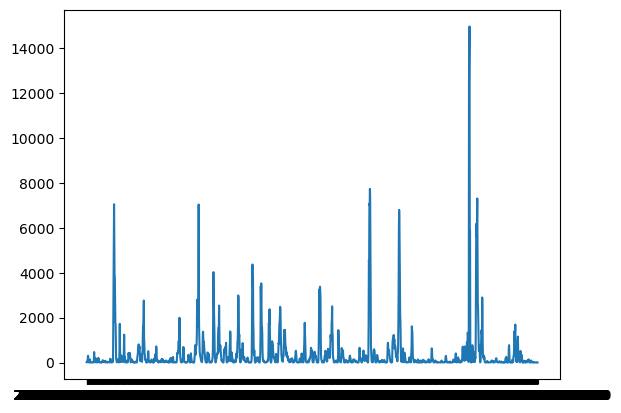

In [13]:
plt.plot(day_strike.index, day_strike.InterCloud)
print(max(day_strike.index))

In [14]:
### Get the station data

#st = pd.read_csv("/projects/old_shared/Quebec_fwi_viz/718270-99999.linear.DailyFWIfromHourlyInterp.csv") ## Corrected record from Robert

st = pd.read_csv("s3://veda-data-store-staging/EIS/other/station-FWI/19900101.NRT/FWI/718270-99999.linear.HourlyFWIFromHourlyInterpContinuous.csv") ## Corrected record from Robert

#st = st[0:9672] # Cut out extra excel cells
st['HH'] = st.HH.astype("int")#'12'
st.YYYY = st.YYYY.astype("int")
st.MM = st.MM.astype("int")
st.DD = st.DD.astype("int")
st = fv.date_convert(st)

st['MM_DD'] = st['time'].apply(lambda x: x.strftime('%m-%d'))

#st['ismayjune'] = np.logical_or((st.MM == 6), (st.MM == 5))
st['ismayjune'] = st.MM.isin([5, 6, 7]) # Is May, June or July? 
mj = st[st['ismayjune'] == True]
mj = mj.set_index("time")
#st = st.set_index("time")

mj = mj[mj.index > "1991-01-01 00:00:00"]
mj = mj[mj.index < "2020-12-31 23:00:00"]

#
mean_quant = mj.groupby([mj.index.day, mj.index.month]).mean()

dates = ("2023-" + mean_quant.index.get_level_values(level=1).astype("str") + "-" + mean_quant.index.get_level_values(level=0).astype("str"))

mean_quant["dates"] = pd.to_datetime(dates)
mean_quant = mean_quant.sort_values(by = "dates")
mean_quant.set_index("dates", inplace = True)


upper = mj.groupby([mj.index.day, mj.index.month]).quantile((1-0.025))
upper["dates"] = pd.to_datetime(dates)
upper = upper.sort_values(by = "dates")
upper.set_index("dates", inplace = True)

lower = mj.groupby([mj.index.day, mj.index.month]).quantile(0.025)
lower["dates"] = pd.to_datetime(dates)
lower = lower.sort_values(by = "dates")
lower.set_index("dates", inplace = True)


mid_lower = mj.groupby([mj.index.day, mj.index.month]).quantile(0.25)
mid_lower["dates"] = pd.to_datetime(dates)
mid_lower = mid_lower.sort_values(by = "dates")
mid_lower.set_index("dates", inplace = True)


mid_upper = mj.groupby([mj.index.day, mj.index.month]).quantile(0.75)
mid_upper["dates"] = pd.to_datetime(dates)
mid_upper = mid_upper.sort_values(by = "dates")
mid_upper.set_index("dates", inplace = True)

/tmp/ipykernel_4389/432698602.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_quant = mj.groupby([mj.index.day, mj.index.month]).mean()
/tmp/ipykernel_4389/432698602.py:35: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  upper = mj.groupby([mj.index.day, mj.index.month]).quantile((1-0.025))
/tmp/ipykernel_4389/432698602.py:40: FutureWarning: The default value of numeric_only in DataFrameGroupBy.quantile is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  lower = mj.groupby([mj.index.d

In [15]:

start_d = "2023-05-28 12:00:00"
end_d = "2023-07-01 12:00:00"
date_range = pd.date_range(start = start_d, end = end_d, freq="12H")
#date_range_format = datetime.strptime(date_rage, 
date_snap = date_range.strftime("%Y%m%d%p")
date_snap
nice_dates = date_range.strftime("%Y-%m-%d %p")

In [21]:
# len(snap[snap.duration == 0].mergeid.unique())

# print(len(snap[snap.n_newpixels > 0].mergeid.unique()))

# #snap

In [74]:
# ### To generate fire stats
# snap_list = []
# for d,n in zip(date_snap, date_range):
#     #print(n)
#     snap = fv.prep_gdf(date = d,layer='perimeter',handle_multi=False,only_lf=False,area_lim=3.7, year = "2023", path_region = "QuebecGlobalNRT_tess")
#     farea = sum(snap.farea)
#     numfires = len(snap.mergeid.unique())
#     num_active_fires = len(snap[snap.n_newpixels > 0].mergeid.unique())
#     tot_frp = sum(snap.meanFRP)
#     mean_frp = snap.meanFRP.mean()
#     igs = len(snap[snap.duration == 0].mergeid.unique())
    
#     snap_list.append([n, farea, numfires, num_active_fires, tot_frp, mean_frp, igs])
    

#     #snap = snap[snap.t ]
# fire_stats = pd.DataFrame(data = snap_list, columns = ["t", "farea", "numfires", "num_active_fires",  "tot_frp", "mean_frp", "igs"])
# fire_stats.to_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/computed_data/exp_Quebec_firestats.csv")

In [16]:
#fire_stats = pd.read_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats/exp_Quebec_firestats.csv")


files = glob.glob("/projects/old_shared/fire_weather_vis/Lightning_analysis/snap_stats/better_boreal_snapstats*.csv")

fire_stats = concat_subsets(files)

In [17]:
fire_stats.t = fire_stats.t.astype("datetime64[ns]") #.dt.tz_localize("UTC")
fire_stats = fire_stats[fire_stats.t > start_d ] # & fire_stats.t < max(date_range)
fire_stats = fire_stats[fire_stats.t < end_d ]

In [18]:
fire_stats = fire_stats[fire_stats.prov_name_en == 'Quebec']

In [19]:
day_strike = day_strike[day_strike.index.astype("datetime64[ns]") > start_d]
day_strike = day_strike[day_strike.index.astype("datetime64[ns]") < end_d]

In [20]:
fire_stats.columns

Index(['Unnamed: 0', 'prov_name_en', 't', 'farea', 'numfires',
       'num_active_fires', 'tot_frp', 'mean_frp', 'igs', 'num_active_pixels',
       'fireID'],
      dtype='object')

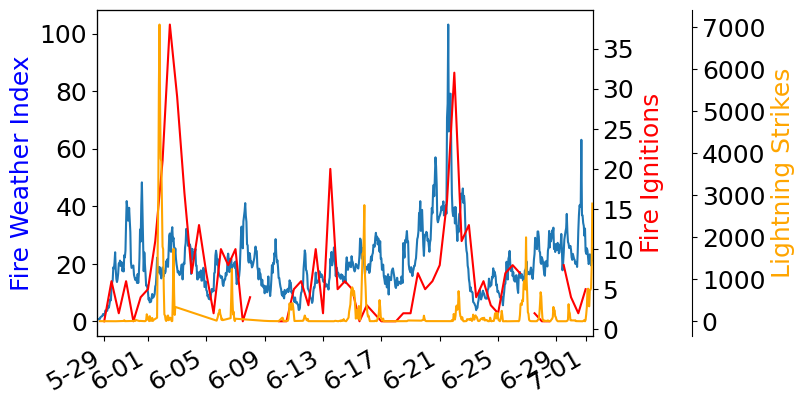

In [23]:
import matplotlib as mpl
import matplotlib.dates as mdates

with mpl.rc_context({'font.size': 18}):
    #plt.plot(day_strike.index, day_strike.InterCloud)
    fig, ax = plt.subplots()
    # ax.fill_between(upper.index, upper.FWI.rolling(5).mean(), lower.FWI.rolling(5).mean(), 
    #                 facecolor='grey', 
    #                 alpha=0.2,
    #                 label= "95th Percentile")
    # ax.fill_between(mid_upper.index, mid_upper.FWI.rolling(5).mean(), mid_lower.FWI.rolling(5).mean(), 
    #                 facecolor='grey', 
    #                 alpha=0.4,
    #                 label= "25th Percentile")
    # ax.plot(mean_quant.index, mean_quant.FWI.rolling(5).mean(), 
    #         color = "black",
    #         label= "Historic Mean Per Day")
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%-m-%d"))
    ax.plot(st[(st.time >= start_d)].time.astype('datetime64[ns]'), st[(st.time >= start_d)].FWI)
    ax.set_xlim(min(date_range), max(date_range))
    ax.set_ylabel("Fire Weather Index", color = "blue")
    #ax.set_title("2023 Fire Weather Index (FWI) for La Grande Rivière, Quebec, Canada (WMO ID 718270)")
    ax.set_title("") #Quebec 2023 Wildfire Season
    #ax.legend()
    ax2 = ax.twinx()
    ax2.plot(fire_stats.t, (fire_stats.igs ), color = "red", label = "Fire Area")
    ax2.set_xlim(min(date_range), max(date_range))
    ax2.set_ylabel("Fire Ignitions", color = "Red")
    #ax2.legend(loc = 0.5)
    ax3 = ax.twinx()
    ax3.set_xlim(min(date_range), max(date_range))
    ax3.plot(day_strike.index.astype("datetime64[ns]"), day_strike.InterCloud, color = "orange")
    ax3.set_ylabel("Lightning Strikes", color = "Orange")
    #ax3.set_xlim(min(date_range), max(date_range))
    ax3.spines.right.set_position(("axes", 1.2))
    fig.autofmt_xdate()
    #plt.tight_layout()
    #plt.show()
plt.savefig('Lightning_FWI_Ignition.png', dpi = 900, transparent = True,bbox_inches = "tight")
#plt.plot(day_strike.index, day_strike.InterCloud)

In [24]:
#?plt.savefig

In [25]:
max(day_strike.index.astype("datetime64[ns]"))

Timestamp('2023-07-01 11:00:00')

In [26]:
day_strike.index.astype("datetime64[ns]")

DatetimeIndex(['2023-05-28 17:00:00', '2023-05-28 18:00:00',
               '2023-05-28 19:00:00', '2023-05-29 19:00:00',
               '2023-05-30 08:00:00', '2023-05-30 09:00:00',
               '2023-05-30 10:00:00', '2023-05-31 03:00:00',
               '2023-05-31 04:00:00', '2023-05-31 05:00:00',
               ...
               '2023-07-01 02:00:00', '2023-07-01 03:00:00',
               '2023-07-01 04:00:00', '2023-07-01 05:00:00',
               '2023-07-01 06:00:00', '2023-07-01 07:00:00',
               '2023-07-01 08:00:00', '2023-07-01 09:00:00',
               '2023-07-01 10:00:00', '2023-07-01 11:00:00'],
              dtype='datetime64[ns]', name='t_agg', length=354, freq=None)

In [27]:
from matplotlib import pyplot as plt

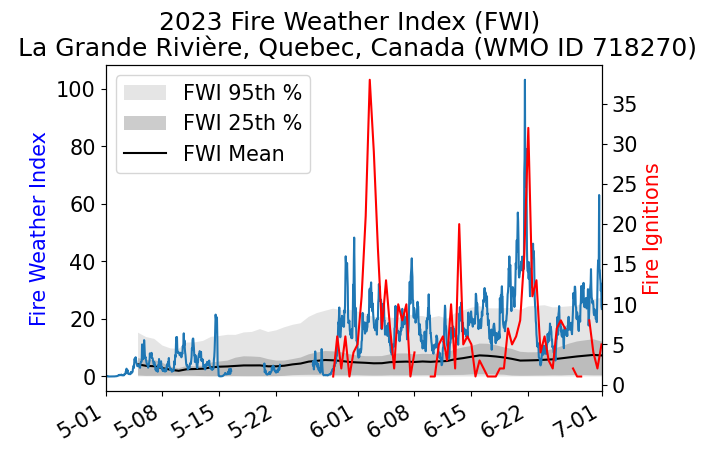

In [39]:
#plt.plot(day_strike.index, day_strike.InterCloud)
#plt.style.use('dark_background')
#plt.style.use('fast')
#plt.style.use('Solarized_Light')
with mpl.rc_context({'font.size': 15}):
    fig, ax = plt.subplots()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%-m-%d"))
    ax.fill_between(upper.index, upper.FWI.rolling(5).mean(), lower.FWI.rolling(5).mean(), 
                    facecolor='grey', 
                    alpha=0.2,
                    label= "FWI 95th %")
    ax.fill_between(mid_upper.index, mid_upper.FWI.rolling(5).mean(), mid_lower.FWI.rolling(5).mean(), 
                    facecolor='grey', 
                    alpha=0.4,
                    label= "FWI 25th %")
    ax.plot(mean_quant.index, mean_quant.FWI.rolling(5).mean(), 
            color = "black",
            label= "FWI Mean")
    ax.plot(st[(st.time >= "2023-05-01")].time.astype('datetime64[ns]'), st[(st.time >= "2023-05-01")].FWI)
    ax.set_ylabel("Fire Weather Index", color = "blue")
    ax.set_title("2023 Fire Weather Index (FWI) \n La Grande Rivière, Quebec, Canada (WMO ID 718270)")
    ax.legend()
    ax.set_xlim(datetime.date(2023, 5, 1), datetime.date(2023, 7, 1))
    ax2 = ax.twinx()
    ax2.plot(fire_stats.t.astype("datetime64[ns]"), fire_stats.igs, color = "red", label = "Number of Fires in Quebec")
    ax2.set_ylabel("Fire Ignitions", color = "Red")
    #ax2.legend(loc = 0.5)
    #ax3 = ax.twinx()
    #ax3.plot(day_strike.index.astype("datetime64[ns]"), day_strike.InterCloud, color = "orange")

    fig.autofmt_xdate()
    #fig.show()
plt.savefig('FWI_historical_Ignition.png', dpi = 900, transparent = True, bbox_inches = "tight")